# Overview
Please understand the below mentioned real-life scenario and try to solve the challenge.

### Business Scenario
You are a data analyst and have a large ecommerce company in India (let’s call it X) as a client.
X gets a few thousand orders via their website on a daily basis and they have to deliver them as
fast as they can. For delivering the goods ordered by the customers, X has tied up with multiple
courier companies in India who charge them some amount per delivery.

The charges are dependent upon two factors:

            - Weight of the product. 

            - Distance between the warehouse (pickup location) and customer’s delivery address (destination location).
             
On an average, the delivery charges are Rs. 100 per shipment. So if X ships 1,00,000 orders per month, they have to pay approximately Rs. 1 crore to the courier companies on a monthly basis as charges.

As the amount that X has to pay to the courier companies is very high, they want to verify if the charges levied by their partners per Order are correct. 

### Input Data

Left Hand Side (LHS) Data (X’s internal data spread across three reports)
 
- Website order report which will list Order IDs and various products (SKUs) part of each order. Order ID is common identifier between X’s order report and courier company invoice.
- SKU master with gross weight of each product. This should be used to calculate total weight of each order and during analysis compare against one reported by courier company in their CSV invoice per Order ID. The courier company calculates weight in slabs of 0.5 KG multiples, so first you have to figure out the total weight of the shipment and then figure out applicable weight slabs.

For example:

- If the total weight is 400 gram then weight slab should be 0.5
- If the total weight is 950 gram then weight slab should be 1
- If the total weight is 1 KG then weight slab should be 1
- If the total weight is 2.2 KG then weight slab should be 2.5
- Warehouse pincode to All India pincode mapping (this should be used to figure out delivery zone (a/b/c/d/e) and during analysis compare against one reported by courier company in their CSV invoice per Order ID

### RHS Data (courier company invoice in CSV file)
- Invoice in CSV file mentioning AWB Number (courier company’s own internal ID), Order ID (company X’s order ID), weight of shipment, warehouse pickup pincode, customer delivery pincode, zone of delivery, charges per shipment, type of shipment
- Courier charges rate card at weight slab and pincode level. If the invoice mentions “Forward charges” then only forward charges (“fwd”) should be applicable as per zone and fixed & additional weights based on weight slabs. If the invoice mentions “Forward and rto charges” then forward charges (“fwd”) and RTO charges (“rto”) should be applicable as per zone and fixed & additional weights based on weight slabs
- For the first 0.5 KG, “fixed” rate as per the slab is applicable. For each additional 0.5 KG, “additional” weight in the same proportion is applicable. Total charges will be “fixed” + “total additional” if any

### Output Data 1
Create a resultant CSV/Excel file with the following columns:

        - Order ID
        
        - AWB Number
        
        - Total weight as per X (KG)
        
        - Weight slab as per X (KG)
        
        - Total weight as per Courier Company (KG)
        
        - Weight slab charged by Courier Company (KG)
        
        - Delivery Zone as per X
        
        - Delivery Zone charged by Courier Company
        
        - Expected Charge as per X (Rs.)
        
        - Charges Billed by Courier Company (Rs.)
        
        - Difference Between Expected Charges and Billed Charges (Rs.)

### Output Data 2
Create Summary Table

# Importing Libraries

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing Datasets

In [56]:
order = pd.read_excel(r"C:\Users\aryan\OneDrive\Desktop\DS PROJECTS\BIG PROJECT\SUPPLY CHAIN MANAGEMENT (6)\Company X - Order Report(1).xlsx")
sku = pd.read_excel(r"C:\Users\aryan\OneDrive\Desktop\DS PROJECTS\BIG PROJECT\SUPPLY CHAIN MANAGEMENT (6)\Company X - SKU Master(1).xlsx")
pincode = pd.read_excel(r"C:\Users\aryan\OneDrive\Desktop\DS PROJECTS\BIG PROJECT\SUPPLY CHAIN MANAGEMENT (6)\Company X - Pincode Zones(1).xlsx")
invoice = pd.read_excel(r"C:\Users\aryan\OneDrive\Desktop\DS PROJECTS\BIG PROJECT\SUPPLY CHAIN MANAGEMENT (6)\Courier Company - Invoice(1).xlsx")
rates = pd.read_excel(r"C:\Users\aryan\OneDrive\Desktop\DS PROJECTS\BIG PROJECT\SUPPLY CHAIN MANAGEMENT (6)\Courier Company - Rates(1).xlsx")

## Viewing the Datasets 

In [77]:
order.head()

,ExternOrderNo,SKU,Order Qty
0,2001827036,8904223818706,1.0
1,2001827036,8904223819093,1.0
2,2001827036,8904223819109,1.0
3,2001827036,8904223818430,1.0
4,2001827036,8904223819277,1.0


In [78]:
sku.head()

,SKU,Weight (g)
0,8904223815682,210
1,8904223815859,165
2,8904223815866,113
3,8904223815873,65
4,8904223816214,120


In [76]:
pincode.head()

,Warehouse Pincode,Customer Pincode,Zone
0,121003,507101,d
1,121003,486886,d
2,121003,532484,d
3,121003,143001,b
4,121003,515591,d


In [74]:
invoice.head()

,AWB Code,Order ID,Charged Weight,Warehouse Pincode,Customer Pincode,Zone,Type of Shipment,Billing Amount (Rs.)
0,1091117222124,2001806232,1.30,121003,507101,d,Forward charges,135.0
1,1091117222194,2001806273,1.00,121003,486886,d,Forward charges,90.2
2,1091117222931,2001806408,2.50,121003,532484,d,Forward charges,224.6
3,1091117223244,2001806458,1.00,121003,143001,b,Forward charges,61.3
4,1091117229345,2001807012,0.15,121003,515591,d,Forward charges,45.4


In [73]:
rates.head()

,fwd_a_fixed,fwd_a_additional,fwd_b_fixed,fwd_b_additional,fwd_c_fixed,fwd_c_additional,fwd_d_fixed,fwd_d_additional,fwd_e_fixed,fwd_e_additional,rto_a_fixed,rto_a_additional,rto_b_fixed,rto_b_additional,rto_c_fixed,rto_c_additional,rto_d_fixed,rto_d_additional,rto_e_fixed,rto_e_additional
0,29.5,23.6,33,28.3,40.1,38.9,45.4,44.8,56.6,55.5,13.6,23.6,20.5,28.3,31.9,38.9,41.3,44.8,50.7,55.5


##  Viewing the statistical summary of the datasets

In [80]:
order.describe()

,ExternOrderNo,Order Qty
count,4.000000e+02,400.000000
mean,2.001811e+09,1.297500
std,5.187698e+03,0.919842
min,2.001806e+09,1.000000
25%,2.001807e+09,1.000000
50%,2.001809e+09,1.000000
75%,2.001812e+09,1.000000
max,2.001827e+09,8.000000


In [81]:
sku.describe()

,Weight (g)
count,66.000000
mean,219.742424
std,146.855482
min,10.000000
25%,116.250000
50%,165.000000
75%,290.000000
max,600.000000


In [82]:
pincode.describe()

,Warehouse Pincode,Customer Pincode
count,124.0,124.000000
mean,121003.0,365488.072581
std,0.0,152156.322130
min,121003.0,140301.000000
25%,121003.0,302017.000000
50%,121003.0,321304.500000
75%,121003.0,405102.250000
max,121003.0,845438.000000


In [83]:
invoice.describe()

,AWB Code,Order ID,Charged Weight,Warehouse Pincode,Customer Pincode,Billing Amount (Rs.)
count,1.240000e+02,1.240000e+02,124.000000,124.0,124.000000,124.000000
mean,1.091118e+12,2.001811e+09,0.956048,121003.0,365488.072581,110.066129
std,1.473661e+06,5.167329e+03,0.662815,0.0,152156.322130,64.060832
min,1.091117e+12,2.001806e+09,0.150000,121003.0,140301.000000,33.000000
25%,1.091117e+12,2.001807e+09,0.667500,121003.0,302017.000000,86.700000
50%,1.091117e+12,2.001809e+09,0.725000,121003.0,321304.500000,90.200000
75%,1.091119e+12,2.001812e+09,1.100000,121003.0,405102.250000,135.000000
max,1.091122e+12,2.001827e+09,4.130000,121003.0,845438.000000,403.800000


In [84]:
rates.describe()

,fwd_a_fixed,fwd_a_additional,fwd_b_fixed,fwd_b_additional,fwd_c_fixed,fwd_c_additional,fwd_d_fixed,fwd_d_additional,fwd_e_fixed,fwd_e_additional,rto_a_fixed,rto_a_additional,rto_b_fixed,rto_b_additional,rto_c_fixed,rto_c_additional,rto_d_fixed,rto_d_additional,rto_e_fixed,rto_e_additional
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,29.5,23.6,33.0,28.3,40.1,38.9,45.4,44.8,56.6,55.5,13.6,23.6,20.5,28.3,31.9,38.9,41.3,44.8,50.7,55.5
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,29.5,23.6,33.0,28.3,40.1,38.9,45.4,44.8,56.6,55.5,13.6,23.6,20.5,28.3,31.9,38.9,41.3,44.8,50.7,55.5
25%,29.5,23.6,33.0,28.3,40.1,38.9,45.4,44.8,56.6,55.5,13.6,23.6,20.5,28.3,31.9,38.9,41.3,44.8,50.7,55.5
50%,29.5,23.6,33.0,28.3,40.1,38.9,45.4,44.8,56.6,55.5,13.6,23.6,20.5,28.3,31.9,38.9,41.3,44.8,50.7,55.5
75%,29.5,23.6,33.0,28.3,40.1,38.9,45.4,44.8,56.6,55.5,13.6,23.6,20.5,28.3,31.9,38.9,41.3,44.8,50.7,55.5
max,29.5,23.6,33.0,28.3,40.1,38.9,45.4,44.8,56.6,55.5,13.6,23.6,20.5,28.3,31.9,38.9,41.3,44.8,50.7,55.5


## Viewing the information of the datasets

In [67]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ExternOrderNo  400 non-null    int64  
 1   SKU            400 non-null    object 
 2   Order Qty      400 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.5+ KB


In [68]:
sku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SKU         66 non-null     object
 1   Weight (g)  66 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


In [69]:
pincode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Warehouse Pincode  124 non-null    int64 
 1   Customer Pincode   124 non-null    int64 
 2   Zone               124 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.0+ KB


In [70]:
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AWB Code              124 non-null    int64  
 1   Order ID              124 non-null    int64  
 2   Charged Weight        124 non-null    float64
 3   Warehouse Pincode     124 non-null    int64  
 4   Customer Pincode      124 non-null    int64  
 5   Zone                  124 non-null    object 
 6   Type of Shipment      124 non-null    object 
 7   Billing Amount (Rs.)  124 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 7.9+ KB


In [71]:
rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fwd_a_fixed       1 non-null      float64
 1   fwd_a_additional  1 non-null      float64
 2   fwd_b_fixed       1 non-null      int64  
 3   fwd_b_additional  1 non-null      float64
 4   fwd_c_fixed       1 non-null      float64
 5   fwd_c_additional  1 non-null      float64
 6   fwd_d_fixed       1 non-null      float64
 7   fwd_d_additional  1 non-null      float64
 8   fwd_e_fixed       1 non-null      float64
 9   fwd_e_additional  1 non-null      float64
 10  rto_a_fixed       1 non-null      float64
 11  rto_a_additional  1 non-null      float64
 12  rto_b_fixed       1 non-null      float64
 13  rto_b_additional  1 non-null      float64
 14  rto_c_fixed       1 non-null      float64
 15  rto_c_additional  1 non-null      float64
 16  rto_d_fixed       1 non-null      float64
 17  r

## Checking that the dataset containing the null values or not

In [87]:
order.isnull().sum()

ExternOrderNo    0
SKU              0
Order Qty        0
dtype: int64

In [88]:
sku.isnull().sum()

SKU           0
Weight (g)    0
dtype: int64

In [90]:
pincode.isnull().sum()

Warehouse Pincode    0
Customer Pincode     0
Zone                 0
dtype: int64

In [91]:
invoice.isnull().sum()

AWB Code                0
Order ID                0
Charged Weight          0
Warehouse Pincode       0
Customer Pincode        0
Zone                    0
Type of Shipment        0
Billing Amount (Rs.)    0
dtype: int64

In [92]:
rates.isnull().sum()

fwd_a_fixed         0
fwd_a_additional    0
fwd_b_fixed         0
fwd_b_additional    0
fwd_c_fixed         0
fwd_c_additional    0
fwd_d_fixed         0
fwd_d_additional    0
fwd_e_fixed         0
fwd_e_additional    0
rto_a_fixed         0
rto_a_additional    0
rto_b_fixed         0
rto_b_additional    0
rto_c_fixed         0
rto_c_additional    0
rto_d_fixed         0
rto_d_additional    0
rto_e_fixed         0
rto_e_additional    0
dtype: int64

# STEP 1: Total Weight & Weight Slab Calculation (Company X)

###  Merge Order Report with SKU Master

In [94]:
order = order.merge(sku, on = 'SKU', how = 'left')

### Calculate Item Weight in Kilograms

In [97]:
order["Weight_kg"] = (order["Order Qty"] * order["Weight (g)"]) / 1000


###  Calculate Total Weight per Order

In [107]:
order_weight = order.groupby("ExternOrderNo", as_index=False)["Weight_kg"].sum()

### Define Weight Slab Function (0.5 KG Rule)

In [108]:
def weight_slab(weight):
    return np.ceil(weight / 0.5) * 0.5

### Apply Weight Slab Calculation

In [111]:
order_weight["Weight_Slab_X"] = order_weight["Weight_kg"].apply(weight_slab)

# Order-wise Total Weight & Weight Slab (As per Company X)

In [106]:
order_weight.head()

,ExternOrderNo,Weight_kg,Weight_Slab_X
0,2001806210,0.220,0.5
1,2001806226,0.480,0.5
2,2001806229,0.500,0.5
3,2001806232,1.302,1.5
4,2001806233,0.245,0.5


# STEP 2: Courier Weight, Weight Slab & Zone (Courier Company Data)

### Rename Columns for Clarity

In [112]:
invoice = invoice.rename(columns ={
    'Charged Weight':"Weight_Courier",
    "Zone": "Zone_Courier"
})

### Define Weight Slab Function (Same 0.5 KG Rule)

In [115]:
def weight_slab(weight):
    return np.ceil(weight / 0.5) * 0.5

### Calculate Courier Weight Slab

In [117]:
invoice["Weight_Slab_Courier"] = invoice["Weight_Courier"].apply(weight_slab)

### Select Required Columns (Order-Level)

In [118]:
courier_data = invoice[[
    "AWB Code",
    "Order ID",
    "Weight_Courier",
    "Weight_Slab_Courier",
    "Zone_Courier",
    "Billing Amount (Rs.)",
    "Type of Shipment",
    "Warehouse Pincode",
    "Customer Pincode"
]]

# Courier Invoice Details

In [119]:
courier_data.head()

,AWB Code,Order ID,Weight_Courier,Weight_Slab_Courier,Zone_Courier,Billing Amount (Rs.),Type of Shipment,Warehouse Pincode,Customer Pincode
0,1091117222124,2001806232,1.30,1.5,d,135.0,Forward charges,121003,507101
1,1091117222194,2001806273,1.00,1.0,d,90.2,Forward charges,121003,486886
2,1091117222931,2001806408,2.50,2.5,d,224.6,Forward charges,121003,532484
3,1091117223244,2001806458,1.00,1.0,b,61.3,Forward charges,121003,143001
4,1091117229345,2001807012,0.15,0.5,d,45.4,Forward charges,121003,515591


# STEP 3: Delivery Zone as per Company X (Using Pincode Mapping)

### Merge Courier Data with Pincode Mapping
Using Warehouse and Customer Pincode

In [121]:
courier_zone = courier_data.merge(
    pincode,
    on=["Warehouse Pincode", "Customer Pincode"],
    how="left"
)

### Rename Zone Column for Clarity

In [124]:
courier_zone = courier_zone.rename(columns={
    "Zone": "Zone_X"
})


### Select Required Columns (Clean Order-Level Table)

In [127]:
zone_comparison = courier_zone[[
    "AWB Code",
    "Order ID",
    "Zone_X",
    "Zone_Courier",
    "Warehouse Pincode",
    "Customer Pincode"
]]

# Validate the datasetDelivery Zone Comparison: Company X vs Courier

In [129]:
zone_comparison.head()

,AWB Code,Order ID,Zone_X,Zone_Courier,Warehouse Pincode,Customer Pincode
0,1091117222124,2001806232,d,d,121003,507101
1,1091117222194,2001806273,d,d,121003,486886
2,1091117222931,2001806408,d,d,121003,532484
3,1091117223244,2001806458,b,b,121003,143001
4,1091117229345,2001807012,d,d,121003,515591


# STEP 4: Calculate Expected Charges as per Company X

### Merge All Required Data
Order weight, Zone and Courier information

In [130]:
final_df = courier_zone.merge(
    order_weight,
    left_on="Order ID",
    right_on="ExternOrderNo",
    how="left"
)

### Define Expected Charge Calculation Logic

In [131]:
def expected_charge(row):
    zone = row["Zone_X"].lower()
    slab = row["Weight_Slab_X"]
    shipment = row["Type of Shipment"]

    # Choose rate type
    rate_type = "fwd" if shipment == "Forward charges" else "rto"

    fixed = rates[f"{rate_type}_{zone}_fixed"].values[0]
    additional = rates[f"{rate_type}_{zone}_additional"].values[0]

    if slab <= 0.5:
        return fixed
    else:
        extra_slabs = (slab - 0.5) / 0.5
        return fixed + (extra_slabs * additional)


### Apply Expected Charge Calculation

In [132]:
final_df["Expected_Charge_X"] = final_df.apply(expected_charge, axis=1)

# Expected Courier Charges as per Company X (Order-Level)

In [133]:
final_df[[
    "Order ID",
    "Weight_Slab_X",
    "Zone_X",
    "Type of Shipment",
    "Expected_Charge_X"
]].head()


,Order ID,Weight_Slab_X,Zone_X,Type of Shipment,Expected_Charge_X
0,2001806232,1.5,d,Forward charges,135.0
1,2001806273,1.0,d,Forward charges,90.2
2,2001806408,2.5,d,Forward charges,224.6
3,2001806458,1.0,b,Forward charges,61.3
4,2001807012,0.5,d,Forward charges,45.4


# STEP 5: Overcharged / Undercharged Analysis & Summary

### Calculate Charge Difference

In [136]:
final_df["Charge_Difference"] = (
    final_df["Billing Amount (Rs.)"] - final_df["Expected_Charge_X"]
)

### Classify Orders

In [137]:
def charge_status(diff):
    if diff > 0:
        return "Overcharged"
    elif diff < 0:
        return "Undercharged"
    else:
        return "Correctly Charged"

final_df["Charge_Status"] = final_df["Charge_Difference"].apply(charge_status)

### Create Summary Table

In [138]:
summary = final_df.groupby("Charge_Status").agg(
    Count=("Order ID", "count"),
    Amount_Rs=("Charge_Difference", "sum")
).reset_index()


## Summary

In [139]:
summary

,Charge_Status,Count,Amount_Rs
0,Correctly Charged,18,0.0
1,Overcharged,142,7840.7
2,Undercharged,14,-682.8


# Overcharged vs Undercharged Orders

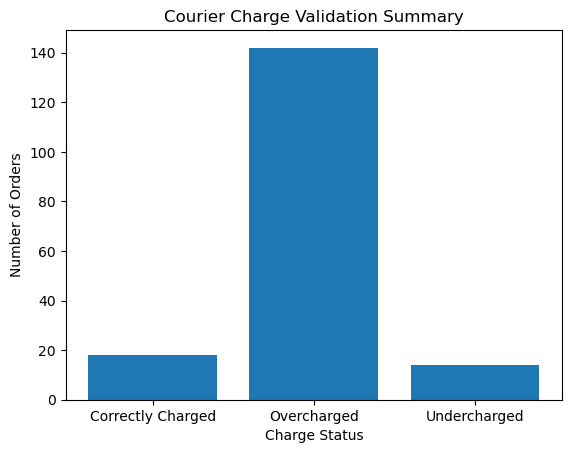

In [142]:
plt.bar(summary["Charge_Status"], summary["Count"])
plt.title("Courier Charge Validation Summary")
plt.xlabel("Charge Status")
plt.ylabel("Number of Orders")
plt.show()

# Amount Impact by Charge Status (Rs.)
This shows financial impact, which is very relevant to supply chain cost auditing.

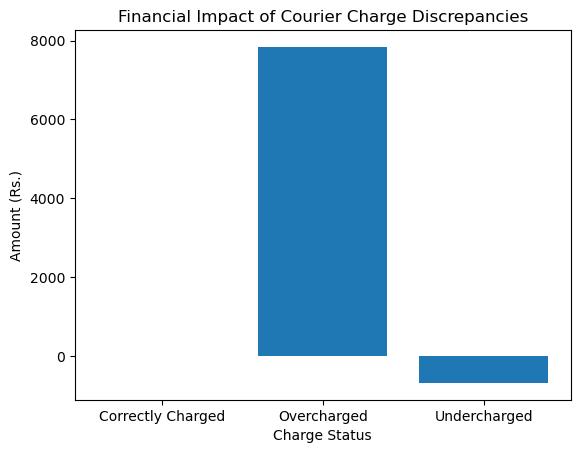

In [145]:
plt.bar(summary["Charge_Status"], summary["Amount_Rs"])
plt.title("Financial Impact of Courier Charge Discrepancies")
plt.xlabel("Charge Status")
plt.ylabel("Amount (Rs.)")
plt.show()

# Zone-wise Overcharging / Undercharging

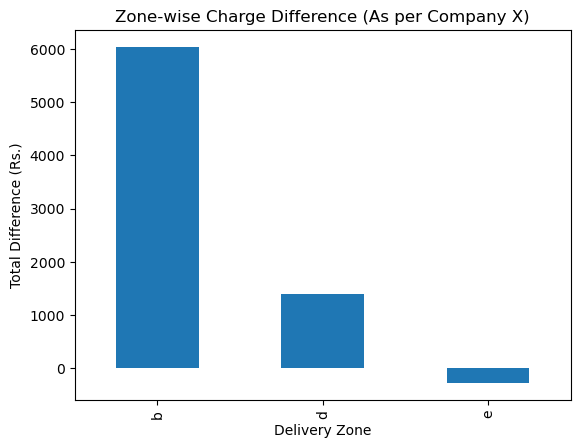

In [146]:
zone_summary = final_df.groupby("Zone_X")["Charge_Difference"].sum()

zone_summary.plot(kind="bar")
plt.title("Zone-wise Charge Difference (As per Company X)")
plt.xlabel("Delivery Zone")
plt.ylabel("Total Difference (Rs.)")
plt.show()

# Key Insights

- A noticeable number of orders show a difference between expected courier charges and billed charges, indicating billing inconsistencies.

- Overcharged orders lead to avoidable logistics costs and directly increase Company X’s monthly courier expenses.

- Undercharged orders, although financially favorable in the short term, reflect inconsistencies in courier billing and may cause reconciliation issues later.

- Weight slab mismatches between Company X calculations and courier-charged slabs are a major contributor to charge discrepancies.

- Incorrect or inconsistent zone allocation (Company X vs Courier) impacts the final delivery charge and leads to pricing errors.

- Certain delivery zones contribute more heavily to overall charge differences, highlighting areas that need closer monitoring.

- Using Company X’s internal SKU-level weight calculation provides a more accurate benchmark for validating courier invoices.

- A structured, order-level verification process enables better cost control and invoice auditing in supply chain operations.

# Conclusion

This analysis was conducted to verify the accuracy of courier charges billed to Company X using its internal order data, SKU weight information, pincode-based zone mapping, and the courier company’s rate card. By calculating the expected delivery charges as per Company X and comparing them with the actual charges billed by the courier company, we identified cases of overcharging, undercharging, and correct billing at an order level.

The results show that:

- A significant number of orders were not billed correctly, indicating discrepancies between expected and billed courier charges.

- Overcharged orders contribute to unnecessary logistics costs, directly impacting Company X’s operational expenses.

- Undercharged orders, while beneficial in the short term, highlight inconsistencies in billing practices that may lead to future disputes.

- Zone-wise and amount-based summaries help identify specific delivery zones where charge discrepancies are more frequent.

Overall, this analysis provides actionable business insights that can help Company X:

- Audit courier invoices more effectively

- Control and reduce logistics costs

- Strengthen negotiations with courier partners

- Improve transparency and accuracy in supply chain billing

The step-by-step approach followed in this study is fully aligned with the problem statement, uses basic and interpretable methods, and produces reliable results suitable for business decision-making.

# Recommendations

- Company X should implement an automated courier invoice audit system using internally calculated weight slabs and zone mapping.

- Regular zone and weight slab reconciliation should be conducted to minimize billing discrepancies.

- Courier partners showing frequent overcharging trends should be reviewed and renegotiated.

- Standardizing SKU weight records will improve accuracy in expected charge calculations.

- Zone-wise discrepancy monitoring can help identify problematic delivery regions and improve logistics planning.

- Periodic audits will help Company X reduce unnecessary logistics costs and improve operational efficiency.